In [ ]:
#MIT License

#Copyright (c) [2021] [Oliver Böhme]

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

In [1]:
#Problem Framing:

#There are many ways to harness and explore a given dataset.
#In this paper, we will use the data to explore a very specific question; that is:
#Given recent number of problems and influencal factors what is the expected number of problems for the upcoming time steps until we reach SOP?

#This requires that a predictive model forecasts the total number of errors for each week over the residual weeks.

#Technically, this framing of the problem is referred to as a multivariate multi-step time series forecasting problem, given the multiple forecast steps. 
#A model, that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.
#A model of this type could be helpful within the <Anwendungsfall>
#It could also be helpful on the <Anwendungsfall>.

#Data Description
#Non-stationarity is when the statistical properties of a series, e.g the mean, variance, and covariance (or the process generating the series) changes over time. 
#Non-stationary series are typically difficult to model and forecast and are therefore required to be made stationary to obtain meaningful results as many statistical tools and processes require stationarity. 
#A proven method of stationarizing a non-stationary series is through the use of differencing.

#Credits
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [20]:
#Import Libraries:

import pandas as pd
from pandas import read_csv
from pandas import to_numeric

import numpy as np
from numpy import split
from numpy import array
from numpy import nan
from numpy import isnan

import csv
import math
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, GRU, Flatten, RepeatVector, TimeDistributed
from tcn import TCN, tcn_full_summary #https://github.com/philipperemy/keras-tcn

import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


Shape of the Dataset_raw:  (49920, 11)


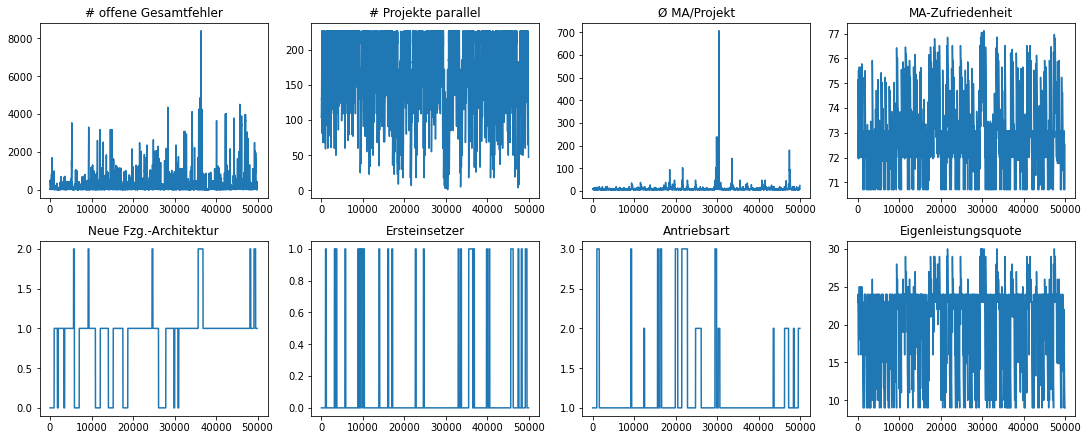

In [3]:
#Import DataSet:

data_raw = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/DataSet_Prediction_multivariat_preprocessed_feature selected_v04e_20211003_OB.xlsm',0)
print('Shape of the Dataset_raw: ',data_raw.shape)
data_raw.head()

#Drop unneccessary Columns:
dataset = data_raw.iloc[:,3:11]

#Plot the Data
figure, axis = plt.subplots(2,4, figsize=(15,6), constrained_layout=True)

axis[0,0].plot(dataset.iloc[:,0:1])
axis[0,0].set_title("# offene Gesamtfehler")

axis[0,1].plot(dataset.iloc[:,1:2])
axis[0,1].set_title("# Projekte parallel")

axis[0,2].plot(dataset.iloc[:,2:3])
axis[0,2].set_title("Ø MA/Projekt")

axis[0,3].plot(dataset.iloc[:,3:4])
axis[0,3].set_title("MA-Zufriedenheit")

axis[1,0].plot(dataset.iloc[:,4:5])
axis[1,0].set_title("Neue Fzg.-Architektur")

axis[1,1].plot(dataset.iloc[:,5:6])
axis[1,1].set_title("Ersteinsetzer")

axis[1,2].plot(dataset.iloc[:,6:7])
axis[1,2].set_title("Antriebsart")

axis[1,3].plot(dataset.iloc[:,7:8])
axis[1,3].set_title("Eigenleistungsquote")

plt.show()

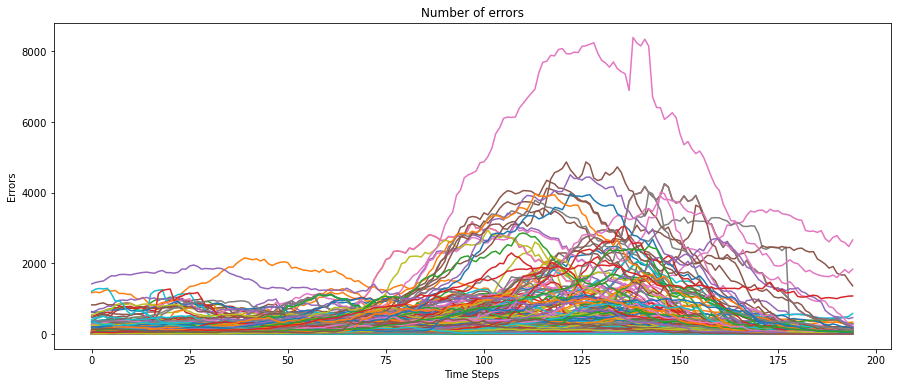

In [4]:
#Plot offene Gesamtfehler
projects2visualize = dataset
time = np.arange(len(projects2visualize))

plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Number of errors")
    
for i in range(0,256):
    plt.plot(time[0:195], projects2visualize.iloc[i*195:((i*195)+195),0:1])

plt.show()


In [11]:
#Choose Feature Set:
dataset = data_raw.iloc[:,3:5]
print('Shape of the Dataset: ',dataset.shape)
print(dataset.head())


Shape of the Dataset:  (49920, 2)
   Anzahl offene Gesamtfehler  Anzahl parallel entwickelter Projekte
0                          21                                    104
1                          16                                    104
2                          12                                    104
3                          12                                    106
4                          12                                    109


In [12]:
#Define Length of Input/Output Sequences:

n_input = 135
n_out = 60


In [13]:
#Split multivariate DataSet into Train/ Test Sets:

#Normalize Dataset
#scaler = MinMaxScaler()
#dataset_scaled = scaler.fit_transform(dataset)


#Split into Length of Car Projects (195 time stamps)
split_time = math.ceil(0.5*len(dataset)/195)*195 #Ratio: 70/30 #Define Ratio Train/Test-Split
train, test = dataset[:split_time], dataset[split_time:]
#train, test = dataset_scaled[:split_time], dataset_scaled[split_time:] #Normalize Data
    
#Restructure into Windows of Length of one Verhicle Project
train = array(split(train, len(train)/195))
test = array(split(test, len(test)/195))


#Testing/Bugfixing
print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)


Train Shape:  (128, 195, 2)
Test Shape:  (128, 195, 2)


In [14]:
#Data Preparation: Convert Train-DataSet into Inputs and Outputs:

#Flatten Data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

X, y = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_input = data[in_start:in_end, 0]
        X_input = X_input.reshape((len(X_input), 1))
        X.append(data[in_start:in_end, :])
        y.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

train_y = array(y)
#Debug
print(array(X).shape)
print(array(y).shape)
#print(array(X)[0:330])
#print(array(y)[0:330])

(128, 135, 2)
(128, 60)


In [15]:
#Data Preparation: Convert Test-DataSet into Inputs and Outputs:

#Flatten Data
data = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))

X_test, y_test = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_test_input = data[in_start:in_end, 0]
        X_test_input = X_test_input.reshape((len(X_test_input), 1))
        X_test.append(data[in_start:in_end, :])
        y_test.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

X_test = array(X_test)
y_test = array(y_test)
#Debug
#print(array(X_test).shape)
#print(array(y_test).shape)
#print(array(X_test)[0:330])
#print(array(y_test)[0:330])

In [16]:
#Define and train the AN_Model:

#Prepare Data
AN_train_x, AN_train_y = array(X), array(y)

#Define Parameters
verbose, epochs, batch_size = 1, 2000, 16
n_timesteps, n_features, n_outputs = AN_train_x.shape[1], AN_train_x.shape[2], AN_train_y.shape[1]
#print("n_timesteps, n_features, n_outputs: ",n_timesteps, n_features, n_outputs)

#Reshape Output into [samples, timesteps, features]
AN_train_y = AN_train_y.reshape((AN_train_y.shape[0], AN_train_y.shape[1], 1)) 
    
#Define Transformer Encoder
#Credits: https://keras.io/examples/timeseries/timeseries_transformer_classification/
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    #Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

#Define Build Model Function
#Credits: https://keras.io/examples/timeseries/timeseries_transformer_classification/
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units=n_out, activation="relu")(x)

    return keras.Model(inputs, outputs)

#Define Model
AN_model = build_model(input_shape=(n_timesteps, n_features), head_size=256, num_heads=1, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25)

AN_model.compile(loss='mae', optimizer='adam')

#Fit the Model
AN_model.fit(AN_train_x, AN_train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/2000
8/8 [==============================] - 2s 82ms/step - loss: 186.8491
Epoch 2/2000
8/8 [==============================] - 1s 85ms/step - loss: 170.0146
Epoch 3/2000
8/8 [==============================] - 1s 79ms/step - loss: 163.5251
Epoch 4/2000
8/8 [==============================] - 1s 79ms/step - loss: 151.6828
Epoch 5/2000
8/8 [==============================] - 1s 79ms/step - loss: 150.0110
Epoch 6/2000
8/8 [==============================] - 1s 77ms/step - loss: 142.3050
Epoch 7/2000
8/8 [==============================] - 1s 77ms/step - loss: 136.1426
Epoch 8/2000
8/8 [==============================] - 1s 78ms/step - loss: 135.5415
Epoch 9/2000
8/8 [==============================] - 1s 76ms/step - loss: 128.2978
Epoch 10/2000
8/8 [==============================] - 1s 77ms/step - loss: 126.1012
Epoch 11/2000
8/8 [==============================] - 1s 77ms/step - loss: 125.5595
Epoch 12/2000
8/8 [==============================] - 1s 77ms/step - loss: 121.0377
Epoch 13/2000

8/8 [==============================] - 1s 75ms/step - loss: 84.5160
Epoch 199/2000
8/8 [==============================] - 1s 75ms/step - loss: 78.9974
Epoch 200/2000
8/8 [==============================] - 1s 75ms/step - loss: 91.1317
Epoch 201/2000
8/8 [==============================] - 1s 75ms/step - loss: 91.6452
Epoch 202/2000
8/8 [==============================] - 1s 74ms/step - loss: 83.3496
Epoch 203/2000
8/8 [==============================] - 1s 75ms/step - loss: 84.9497
Epoch 204/2000
8/8 [==============================] - 1s 76ms/step - loss: 80.9020
Epoch 205/2000
8/8 [==============================] - 1s 75ms/step - loss: 82.3153
Epoch 206/2000
8/8 [==============================] - 1s 77ms/step - loss: 80.0734
Epoch 207/2000
8/8 [==============================] - 1s 78ms/step - loss: 85.5323
Epoch 208/2000
8/8 [==============================] - 1s 77ms/step - loss: 84.2732
Epoch 209/2000
8/8 [==============================] - 1s 76ms/step - loss: 81.7625
Epoch 210/2000
8/8 

8/8 [==============================] - 1s 74ms/step - loss: 77.0269
Epoch 395/2000
8/8 [==============================] - 1s 74ms/step - loss: 80.6273
Epoch 396/2000
8/8 [==============================] - 1s 74ms/step - loss: 84.8091
Epoch 397/2000
8/8 [==============================] - 1s 74ms/step - loss: 81.4777
Epoch 398/2000
8/8 [==============================] - 1s 75ms/step - loss: 81.9595
Epoch 399/2000
8/8 [==============================] - 1s 74ms/step - loss: 82.0236
Epoch 400/2000
8/8 [==============================] - 1s 74ms/step - loss: 76.6425
Epoch 401/2000
8/8 [==============================] - 1s 75ms/step - loss: 80.5041
Epoch 402/2000
8/8 [==============================] - 1s 74ms/step - loss: 80.0349
Epoch 403/2000
8/8 [==============================] - 1s 75ms/step - loss: 81.1290
Epoch 404/2000
8/8 [==============================] - 1s 75ms/step - loss: 78.1241
Epoch 405/2000
8/8 [==============================] - 1s 74ms/step - loss: 78.8465
Epoch 406/2000
8/8 

8/8 [==============================] - 1s 75ms/step - loss: 72.6372
Epoch 591/2000
8/8 [==============================] - 1s 76ms/step - loss: 71.4975
Epoch 592/2000
8/8 [==============================] - 1s 75ms/step - loss: 74.0022
Epoch 593/2000
8/8 [==============================] - 1s 75ms/step - loss: 75.3981
Epoch 594/2000
8/8 [==============================] - 1s 76ms/step - loss: 73.5010
Epoch 595/2000
8/8 [==============================] - 1s 74ms/step - loss: 79.5049
Epoch 596/2000
8/8 [==============================] - 1s 75ms/step - loss: 73.3860
Epoch 597/2000
8/8 [==============================] - 1s 74ms/step - loss: 73.7482
Epoch 598/2000
8/8 [==============================] - 1s 76ms/step - loss: 76.1797
Epoch 599/2000
8/8 [==============================] - 1s 74ms/step - loss: 79.0290
Epoch 600/2000
8/8 [==============================] - 1s 77ms/step - loss: 75.9551
Epoch 601/2000
8/8 [==============================] - 1s 74ms/step - loss: 77.4484
Epoch 602/2000
8/8 

8/8 [==============================] - 1s 76ms/step - loss: 78.0080
Epoch 787/2000
8/8 [==============================] - 1s 76ms/step - loss: 77.4115
Epoch 788/2000
8/8 [==============================] - 1s 75ms/step - loss: 75.7843
Epoch 789/2000
8/8 [==============================] - 1s 75ms/step - loss: 78.0803
Epoch 790/2000
8/8 [==============================] - 1s 75ms/step - loss: 74.7866
Epoch 791/2000
8/8 [==============================] - 1s 75ms/step - loss: 72.1030
Epoch 792/2000
8/8 [==============================] - 1s 76ms/step - loss: 77.1137
Epoch 793/2000
8/8 [==============================] - 1s 77ms/step - loss: 75.2194
Epoch 794/2000
8/8 [==============================] - 1s 75ms/step - loss: 73.3710
Epoch 795/2000
8/8 [==============================] - 1s 77ms/step - loss: 71.8213
Epoch 796/2000
8/8 [==============================] - 1s 76ms/step - loss: 79.2080
Epoch 797/2000
8/8 [==============================] - 1s 75ms/step - loss: 74.1874
Epoch 798/2000
8/8 

8/8 [==============================] - 1s 77ms/step - loss: 74.0598
Epoch 983/2000
8/8 [==============================] - 1s 76ms/step - loss: 75.7326
Epoch 984/2000
8/8 [==============================] - 1s 76ms/step - loss: 73.7902
Epoch 985/2000
8/8 [==============================] - 1s 78ms/step - loss: 74.7761
Epoch 986/2000
8/8 [==============================] - 1s 75ms/step - loss: 77.3732
Epoch 987/2000
8/8 [==============================] - 1s 76ms/step - loss: 70.4404
Epoch 988/2000
8/8 [==============================] - 1s 77ms/step - loss: 71.9339
Epoch 989/2000
8/8 [==============================] - 1s 76ms/step - loss: 72.0467
Epoch 990/2000
8/8 [==============================] - 1s 75ms/step - loss: 78.0186
Epoch 991/2000
8/8 [==============================] - 1s 76ms/step - loss: 74.2596
Epoch 992/2000
8/8 [==============================] - 1s 76ms/step - loss: 75.0428
Epoch 993/2000
8/8 [==============================] - 1s 76ms/step - loss: 76.0573
Epoch 994/2000
8/8 

8/8 [==============================] - 1s 74ms/step - loss: 71.4415
Epoch 1177/2000
8/8 [==============================] - 1s 75ms/step - loss: 78.1494
Epoch 1178/2000
8/8 [==============================] - 1s 74ms/step - loss: 77.2796
Epoch 1179/2000
8/8 [==============================] - 1s 74ms/step - loss: 73.0359
Epoch 1180/2000
8/8 [==============================] - 1s 75ms/step - loss: 71.0508
Epoch 1181/2000
8/8 [==============================] - 1s 76ms/step - loss: 71.5748
Epoch 1182/2000
8/8 [==============================] - 1s 75ms/step - loss: 72.9411
Epoch 1183/2000
8/8 [==============================] - 1s 75ms/step - loss: 71.2187
Epoch 1184/2000
8/8 [==============================] - 1s 74ms/step - loss: 68.5190
Epoch 1185/2000
8/8 [==============================] - 1s 76ms/step - loss: 75.8156
Epoch 1186/2000
8/8 [==============================] - 1s 74ms/step - loss: 82.3261
Epoch 1187/2000
8/8 [==============================] - 1s 76ms/step - loss: 70.9553
Epoch 11

8/8 [==============================] - 1s 74ms/step - loss: 75.0801
Epoch 1371/2000
8/8 [==============================] - 1s 75ms/step - loss: 73.7565
Epoch 1372/2000
8/8 [==============================] - 1s 74ms/step - loss: 71.7213
Epoch 1373/2000
8/8 [==============================] - 1s 74ms/step - loss: 71.5378
Epoch 1374/2000
8/8 [==============================] - 1s 74ms/step - loss: 74.2569
Epoch 1375/2000
8/8 [==============================] - 1s 74ms/step - loss: 74.9448
Epoch 1376/2000
8/8 [==============================] - 1s 74ms/step - loss: 77.2639
Epoch 1377/2000
8/8 [==============================] - 1s 75ms/step - loss: 73.5946
Epoch 1378/2000
8/8 [==============================] - 1s 76ms/step - loss: 73.4330
Epoch 1379/2000
8/8 [==============================] - 1s 74ms/step - loss: 69.8326
Epoch 1380/2000
8/8 [==============================] - 1s 77ms/step - loss: 72.9836
Epoch 1381/2000
8/8 [==============================] - 1s 81ms/step - loss: 76.0601
Epoch 13

8/8 [==============================] - 1s 76ms/step - loss: 73.6480
Epoch 1565/2000
8/8 [==============================] - 1s 76ms/step - loss: 77.2040
Epoch 1566/2000
8/8 [==============================] - 1s 76ms/step - loss: 73.6215
Epoch 1567/2000
8/8 [==============================] - 1s 75ms/step - loss: 73.1430
Epoch 1568/2000
8/8 [==============================] - 1s 76ms/step - loss: 70.4397
Epoch 1569/2000
8/8 [==============================] - 1s 74ms/step - loss: 73.0168
Epoch 1570/2000
8/8 [==============================] - 1s 76ms/step - loss: 71.8289
Epoch 1571/2000
8/8 [==============================] - 1s 79ms/step - loss: 69.3113
Epoch 1572/2000
8/8 [==============================] - 1s 76ms/step - loss: 65.3029
Epoch 1573/2000
8/8 [==============================] - 1s 81ms/step - loss: 74.3606
Epoch 1574/2000
8/8 [==============================] - 1s 75ms/step - loss: 70.3768
Epoch 1575/2000
8/8 [==============================] - 1s 75ms/step - loss: 71.6637
Epoch 15

8/8 [==============================] - 1s 76ms/step - loss: 73.1020
Epoch 1759/2000
8/8 [==============================] - 1s 77ms/step - loss: 69.8262
Epoch 1760/2000
8/8 [==============================] - 1s 75ms/step - loss: 69.3053
Epoch 1761/2000
8/8 [==============================] - 1s 79ms/step - loss: 79.9636
Epoch 1762/2000
8/8 [==============================] - 1s 76ms/step - loss: 70.0754
Epoch 1763/2000
8/8 [==============================] - 1s 77ms/step - loss: 70.2340
Epoch 1764/2000
8/8 [==============================] - 1s 75ms/step - loss: 74.6109
Epoch 1765/2000
8/8 [==============================] - 1s 76ms/step - loss: 71.2233
Epoch 1766/2000
8/8 [==============================] - 1s 75ms/step - loss: 69.8622
Epoch 1767/2000
8/8 [==============================] - 1s 75ms/step - loss: 68.9333
Epoch 1768/2000
8/8 [==============================] - 1s 75ms/step - loss: 77.1046
Epoch 1769/2000
8/8 [==============================] - 1s 77ms/step - loss: 73.1032
Epoch 17

8/8 [==============================] - 1s 77ms/step - loss: 66.1231
Epoch 1953/2000
8/8 [==============================] - 1s 77ms/step - loss: 70.5504
Epoch 1954/2000
8/8 [==============================] - 1s 76ms/step - loss: 71.2822
Epoch 1955/2000
8/8 [==============================] - 1s 77ms/step - loss: 71.2027
Epoch 1956/2000
8/8 [==============================] - 1s 76ms/step - loss: 74.0773
Epoch 1957/2000
8/8 [==============================] - 1s 76ms/step - loss: 72.8639
Epoch 1958/2000
8/8 [==============================] - 1s 77ms/step - loss: 74.9313
Epoch 1959/2000
8/8 [==============================] - 1s 77ms/step - loss: 67.4943
Epoch 1960/2000
8/8 [==============================] - 1s 76ms/step - loss: 69.6433
Epoch 1961/2000
8/8 [==============================] - 1s 77ms/step - loss: 70.3281
Epoch 1962/2000
8/8 [==============================] - 1s 76ms/step - loss: 70.6154
Epoch 1963/2000
8/8 [==============================] - 1s 76ms/step - loss: 64.5806
Epoch 19

In [21]:
#Define and train the TCN_Model:

#Prepare Data
TCN_train_x, TCN_train_y = array(X), array(y)

#Define Parameters
verbose, epochs, batch_size = 1, 2000, 16
n_timesteps, n_features, n_outputs = TCN_train_x.shape[1], TCN_train_x.shape[2], TCN_train_y.shape[1]
#print("n_timesteps, n_features, n_outputs: ",n_timesteps, n_features, n_outputs)

#Reshape Output into [samples, timesteps, features]
TCN_train_y = TCN_train_y.reshape((TCN_train_y.shape[0], TCN_train_y.shape[1], 1)) 

#Define Model
TCN_model = Sequential()

TCN_model.add(TCN(nb_filters=256, nb_stacks=1, dropout_rate=0.0, return_sequences=False, activation='tanh',input_shape=(n_timesteps, n_features)))

TCN_model.add(RepeatVector(n_out))

TCN_model.add(TCN(nb_filters=256, nb_stacks=1, dropout_rate=0.0, return_sequences=True, activation='tanh'))

TCN_model.add(TimeDistributed(Dense(128, activation='relu'))) #We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer.

TCN_model.add(TimeDistributed(Dense(1)))
    
TCN_model.compile(loss='mae', optimizer='adam')

#Fit the Model
TCN_model.fit(TCN_train_x, TCN_train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)


Epoch 1/2000
8/8 [==============================] - 3s 199ms/step - loss: 171.9949
Epoch 2/2000
8/8 [==============================] - 2s 199ms/step - loss: 154.1104
Epoch 3/2000
8/8 [==============================] - 2s 201ms/step - loss: 142.5345
Epoch 4/2000
8/8 [==============================] - 2s 201ms/step - loss: 135.3235
Epoch 5/2000
8/8 [==============================] - 2s 203ms/step - loss: 129.7213
Epoch 6/2000
8/8 [==============================] - 2s 200ms/step - loss: 125.8135
Epoch 7/2000
8/8 [==============================] - 2s 200ms/step - loss: 122.2080
Epoch 8/2000
8/8 [==============================] - 2s 201ms/step - loss: 120.5705
Epoch 9/2000
8/8 [==============================] - 2s 200ms/step - loss: 124.8577
Epoch 10/2000
8/8 [==============================] - 2s 204ms/step - loss: 118.3008
Epoch 11/2000
8/8 [==============================] - 2s 196ms/step - loss: 117.7950
Epoch 12/2000
8/8 [==============================] - 2s 203ms/step - loss: 112.6753
E

8/8 [==============================] - 2s 197ms/step - loss: 70.8927
Epoch 197/2000
8/8 [==============================] - 2s 200ms/step - loss: 72.2971
Epoch 198/2000
8/8 [==============================] - 2s 200ms/step - loss: 72.8694
Epoch 199/2000
8/8 [==============================] - 2s 199ms/step - loss: 75.2450
Epoch 200/2000
8/8 [==============================] - 2s 200ms/step - loss: 71.4278
Epoch 201/2000
8/8 [==============================] - 2s 198ms/step - loss: 74.0975
Epoch 202/2000
8/8 [==============================] - 2s 197ms/step - loss: 73.3070
Epoch 203/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.0056
Epoch 204/2000
8/8 [==============================] - 2s 198ms/step - loss: 68.0101
Epoch 205/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.6196
Epoch 206/2000
8/8 [==============================] - 2s 199ms/step - loss: 68.8560
Epoch 207/2000
8/8 [==============================] - 2s 199ms/step - loss: 73.3641
Epoch 2

8/8 [==============================] - 2s 200ms/step - loss: 66.9343
Epoch 391/2000
8/8 [==============================] - 2s 198ms/step - loss: 67.3415
Epoch 392/2000
8/8 [==============================] - 2s 197ms/step - loss: 71.1215
Epoch 393/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.6776
Epoch 394/2000
8/8 [==============================] - 2s 197ms/step - loss: 71.4651
Epoch 395/2000
8/8 [==============================] - 2s 199ms/step - loss: 69.6967
Epoch 396/2000
8/8 [==============================] - 2s 200ms/step - loss: 68.2085
Epoch 397/2000
8/8 [==============================] - 2s 198ms/step - loss: 69.7501
Epoch 398/2000
8/8 [==============================] - 2s 198ms/step - loss: 67.3611
Epoch 399/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.4689
Epoch 400/2000
8/8 [==============================] - 2s 199ms/step - loss: 67.2635
Epoch 401/2000
8/8 [==============================] - 2s 198ms/step - loss: 66.2446
Epoch 4

8/8 [==============================] - 2s 198ms/step - loss: 65.7919
Epoch 585/2000
8/8 [==============================] - 2s 197ms/step - loss: 67.2809
Epoch 586/2000
8/8 [==============================] - 2s 198ms/step - loss: 66.8747
Epoch 587/2000
8/8 [==============================] - 2s 195ms/step - loss: 66.2696
Epoch 588/2000
8/8 [==============================] - 2s 198ms/step - loss: 73.7462
Epoch 589/2000
8/8 [==============================] - 2s 196ms/step - loss: 67.7842
Epoch 590/2000
8/8 [==============================] - 2s 201ms/step - loss: 70.5087
Epoch 591/2000
8/8 [==============================] - 2s 200ms/step - loss: 67.7544
Epoch 592/2000
8/8 [==============================] - 2s 203ms/step - loss: 67.7351
Epoch 593/2000
8/8 [==============================] - 2s 203ms/step - loss: 69.3727
Epoch 594/2000
8/8 [==============================] - 2s 210ms/step - loss: 67.5923
Epoch 595/2000
8/8 [==============================] - 2s 203ms/step - loss: 69.4740
Epoch 5

8/8 [==============================] - 2s 200ms/step - loss: 75.2846
Epoch 779/2000
8/8 [==============================] - 2s 200ms/step - loss: 73.4326
Epoch 780/2000
8/8 [==============================] - 2s 200ms/step - loss: 70.4746
Epoch 781/2000
8/8 [==============================] - 2s 200ms/step - loss: 70.0758
Epoch 782/2000
8/8 [==============================] - 2s 198ms/step - loss: 75.5752
Epoch 783/2000
8/8 [==============================] - 2s 203ms/step - loss: 72.5180
Epoch 784/2000
8/8 [==============================] - 2s 199ms/step - loss: 71.7113
Epoch 785/2000
8/8 [==============================] - 2s 199ms/step - loss: 69.7154
Epoch 786/2000
8/8 [==============================] - 2s 203ms/step - loss: 71.0053
Epoch 787/2000
8/8 [==============================] - 2s 198ms/step - loss: 69.6873
Epoch 788/2000
8/8 [==============================] - 2s 200ms/step - loss: 70.6282
Epoch 789/2000
8/8 [==============================] - 2s 198ms/step - loss: 69.5692
Epoch 7

8/8 [==============================] - 2s 199ms/step - loss: 67.9512
Epoch 973/2000
8/8 [==============================] - 2s 198ms/step - loss: 76.3169
Epoch 974/2000
8/8 [==============================] - 2s 198ms/step - loss: 79.0742
Epoch 975/2000
8/8 [==============================] - 2s 199ms/step - loss: 75.8831
Epoch 976/2000
8/8 [==============================] - 2s 196ms/step - loss: 74.5735
Epoch 977/2000
8/8 [==============================] - 2s 198ms/step - loss: 78.8765
Epoch 978/2000
8/8 [==============================] - 2s 198ms/step - loss: 74.5692
Epoch 979/2000
8/8 [==============================] - 2s 197ms/step - loss: 70.9272
Epoch 980/2000
8/8 [==============================] - 2s 197ms/step - loss: 69.5685
Epoch 981/2000
8/8 [==============================] - 2s 199ms/step - loss: 69.3695
Epoch 982/2000
8/8 [==============================] - 2s 199ms/step - loss: 71.2045
Epoch 983/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.8884
Epoch 9

8/8 [==============================] - 2s 201ms/step - loss: 69.8416
Epoch 1165/2000
8/8 [==============================] - 2s 199ms/step - loss: 75.6683
Epoch 1166/2000
8/8 [==============================] - 2s 196ms/step - loss: 84.4555
Epoch 1167/2000
8/8 [==============================] - 2s 203ms/step - loss: 79.0625
Epoch 1168/2000
8/8 [==============================] - 2s 199ms/step - loss: 75.9274
Epoch 1169/2000
8/8 [==============================] - 2s 199ms/step - loss: 74.6777
Epoch 1170/2000
8/8 [==============================] - 2s 199ms/step - loss: 75.5512
Epoch 1171/2000
8/8 [==============================] - 2s 199ms/step - loss: 79.1584
Epoch 1172/2000
8/8 [==============================] - 2s 201ms/step - loss: 77.8513
Epoch 1173/2000
8/8 [==============================] - 2s 201ms/step - loss: 73.3374
Epoch 1174/2000
8/8 [==============================] - 2s 199ms/step - loss: 71.9501
Epoch 1175/2000
8/8 [==============================] - 2s 199ms/step - loss: 70.9

8/8 [==============================] - 2s 200ms/step - loss: 81.0967
Epoch 1357/2000
8/8 [==============================] - 2s 205ms/step - loss: 77.0425
Epoch 1358/2000
8/8 [==============================] - 2s 206ms/step - loss: 78.2386
Epoch 1359/2000
8/8 [==============================] - 2s 200ms/step - loss: 73.9396
Epoch 1360/2000
8/8 [==============================] - 2s 199ms/step - loss: 73.1124
Epoch 1361/2000
8/8 [==============================] - 2s 200ms/step - loss: 72.6028
Epoch 1362/2000
8/8 [==============================] - 2s 201ms/step - loss: 73.5692
Epoch 1363/2000
8/8 [==============================] - 2s 203ms/step - loss: 71.3514
Epoch 1364/2000
8/8 [==============================] - 2s 205ms/step - loss: 70.4207
Epoch 1365/2000
8/8 [==============================] - 2s 201ms/step - loss: 70.6777
Epoch 1366/2000
8/8 [==============================] - 2s 200ms/step - loss: 69.0658
Epoch 1367/2000
8/8 [==============================] - 2s 204ms/step - loss: 67.7

8/8 [==============================] - 2s 208ms/step - loss: 68.4285
Epoch 1549/2000
8/8 [==============================] - 2s 201ms/step - loss: 66.2756
Epoch 1550/2000
8/8 [==============================] - 2s 207ms/step - loss: 67.6572
Epoch 1551/2000
8/8 [==============================] - 2s 201ms/step - loss: 67.1680
Epoch 1552/2000
8/8 [==============================] - 2s 200ms/step - loss: 75.6682
Epoch 1553/2000
8/8 [==============================] - 2s 199ms/step - loss: 89.6869
Epoch 1554/2000
8/8 [==============================] - 2s 202ms/step - loss: 90.3892
Epoch 1555/2000
8/8 [==============================] - 2s 201ms/step - loss: 82.8344
Epoch 1556/2000
8/8 [==============================] - 2s 200ms/step - loss: 80.5719
Epoch 1557/2000
8/8 [==============================] - 2s 202ms/step - loss: 78.5510
Epoch 1558/2000
8/8 [==============================] - 2s 203ms/step - loss: 76.6939
Epoch 1559/2000
8/8 [==============================] - 2s 206ms/step - loss: 75.6

8/8 [==============================] - 2s 199ms/step - loss: 71.5645
Epoch 1741/2000
8/8 [==============================] - 2s 201ms/step - loss: 72.5275
Epoch 1742/2000
8/8 [==============================] - 2s 200ms/step - loss: 71.8067
Epoch 1743/2000
8/8 [==============================] - 2s 202ms/step - loss: 71.9873
Epoch 1744/2000
8/8 [==============================] - 2s 200ms/step - loss: 70.7094
Epoch 1745/2000
8/8 [==============================] - 2s 201ms/step - loss: 90.5380
Epoch 1746/2000
8/8 [==============================] - 2s 198ms/step - loss: 94.1309
Epoch 1747/2000
8/8 [==============================] - 2s 199ms/step - loss: 90.4460
Epoch 1748/2000
8/8 [==============================] - 2s 200ms/step - loss: 87.8344
Epoch 1749/2000
8/8 [==============================] - 2s 204ms/step - loss: 86.6695
Epoch 1750/2000
8/8 [==============================] - 2s 209ms/step - loss: 85.3872
Epoch 1751/2000
8/8 [==============================] - 2s 208ms/step - loss: 83.3

8/8 [==============================] - 2s 201ms/step - loss: 82.1680
Epoch 1933/2000
8/8 [==============================] - 2s 205ms/step - loss: 84.1139
Epoch 1934/2000
8/8 [==============================] - 2s 200ms/step - loss: 80.5288
Epoch 1935/2000
8/8 [==============================] - 2s 204ms/step - loss: 80.0334
Epoch 1936/2000
8/8 [==============================] - 2s 201ms/step - loss: 79.4190
Epoch 1937/2000
8/8 [==============================] - 2s 207ms/step - loss: 78.2765
Epoch 1938/2000
8/8 [==============================] - 2s 206ms/step - loss: 79.1063
Epoch 1939/2000
8/8 [==============================] - 2s 203ms/step - loss: 78.0454
Epoch 1940/2000
8/8 [==============================] - 2s 199ms/step - loss: 78.4065
Epoch 1941/2000
8/8 [==============================] - 2s 198ms/step - loss: 78.9650
Epoch 1942/2000
8/8 [==============================] - 2s 200ms/step - loss: 78.7801
Epoch 1943/2000
8/8 [==============================] - 2s 201ms/step - loss: 81.3

In [23]:
#Define and train the GRU_Model:

#Prepare Data
GRU_train_x, GRU_train_y = array(X), array(y)

#Define Parameters
verbose, epochs, batch_size = 1, 2000, 16
n_timesteps, n_features, n_outputs = GRU_train_x.shape[1], GRU_train_x.shape[2], GRU_train_y.shape[1]
#print("n_timesteps, n_features, n_outputs: ",n_timesteps, n_features, n_outputs)

#Reshape Output into [samples, timesteps, features]
GRU_train_y = GRU_train_y.reshape((GRU_train_y.shape[0], GRU_train_y.shape[1], 1)) 
    
#Define Model
GRU_model = Sequential()

GRU_model.add(GRU(1024, activation='tanh', input_shape=(n_timesteps, n_features)))

GRU_model.add(RepeatVector(n_out)) #The Internal representation of the input sequence is repeated multiple times, once for each time step in the output sequence

GRU_model.add(GRU(1024, activation='tanh', return_sequences=True)) #We then define the decoder as an LSTM hidden layer with 200 units. Importantly, the decoder will output the entire sequence, not just the output at the end of the sequence as we did with the encoder. This means that each of the 200 units will output a value for each of the seven days, representing the basis for what to predict for each day in the output sequence.
    
GRU_model.add(TimeDistributed(Dense(512, activation='relu'))) #We will then use a fully connected layer to interpret each time step in the output sequence before the final output layer.
    
GRU_model.add(TimeDistributed(Dense(1))) #Importantly, the output layer predicts a single step in the output sequence, not all seven days at a time. The network therefore outputs a three-dimensional vector with the same structure as the input, with the dimensions [samples, timesteps, features]
    
GRU_model.compile(loss='mae', optimizer='adam')

#Fit the Model
GRU_model.fit(GRU_train_x, GRU_train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)


Epoch 1/2000
8/8 [==============================] - 12s 1s/step - loss: 173.4692
Epoch 2/2000
8/8 [==============================] - 9s 1s/step - loss: 155.0567
Epoch 3/2000
8/8 [==============================] - 9s 1s/step - loss: 151.0079
Epoch 4/2000
8/8 [==============================] - 9s 1s/step - loss: 148.6532
Epoch 5/2000
8/8 [==============================] - 9s 1s/step - loss: 143.8469
Epoch 6/2000
8/8 [==============================] - 9s 1s/step - loss: 136.0012
Epoch 7/2000
8/8 [==============================] - 9s 1s/step - loss: 130.6454
Epoch 8/2000
8/8 [==============================] - 9s 1s/step - loss: 127.3255
Epoch 9/2000
8/8 [==============================] - 9s 1s/step - loss: 132.0789
Epoch 10/2000
8/8 [==============================] - 9s 1s/step - loss: 121.1748
Epoch 11/2000
8/8 [==============================] - 9s 1s/step - loss: 116.6759
Epoch 12/2000
8/8 [==============================] - 9s 1s/step - loss: 118.8481
Epoch 13/2000
8/8 [=================

8/8 [==============================] - 9s 1s/step - loss: 56.1237
Epoch 204/2000
8/8 [==============================] - 9s 1s/step - loss: 53.7588
Epoch 205/2000
8/8 [==============================] - 9s 1s/step - loss: 46.6118
Epoch 206/2000
8/8 [==============================] - 9s 1s/step - loss: 43.9699
Epoch 207/2000
8/8 [==============================] - 9s 1s/step - loss: 42.4675
Epoch 208/2000
8/8 [==============================] - 9s 1s/step - loss: 46.0440
Epoch 209/2000
8/8 [==============================] - 9s 1s/step - loss: 48.1311
Epoch 210/2000
8/8 [==============================] - 9s 1s/step - loss: 51.6867
Epoch 211/2000
8/8 [==============================] - 9s 1s/step - loss: 63.4653
Epoch 212/2000
8/8 [==============================] - 9s 1s/step - loss: 48.0247
Epoch 213/2000
8/8 [==============================] - 9s 1s/step - loss: 50.7310
Epoch 214/2000
8/8 [==============================] - 9s 1s/step - loss: 44.4145
Epoch 215/2000
8/8 [=======================

8/8 [==============================] - 9s 1s/step - loss: 37.5819
Epoch 406/2000
8/8 [==============================] - 9s 1s/step - loss: 39.6432
Epoch 407/2000
8/8 [==============================] - 9s 1s/step - loss: 49.9133
Epoch 408/2000
8/8 [==============================] - 9s 1s/step - loss: 37.5265
Epoch 409/2000
8/8 [==============================] - 9s 1s/step - loss: 38.5486
Epoch 410/2000
8/8 [==============================] - 9s 1s/step - loss: 37.3010
Epoch 411/2000
8/8 [==============================] - 9s 1s/step - loss: 40.1759
Epoch 412/2000
8/8 [==============================] - 9s 1s/step - loss: 38.1144
Epoch 413/2000
8/8 [==============================] - 9s 1s/step - loss: 43.2121
Epoch 414/2000
8/8 [==============================] - 9s 1s/step - loss: 38.1238
Epoch 415/2000
8/8 [==============================] - 9s 1s/step - loss: 49.8498
Epoch 416/2000
8/8 [==============================] - 9s 1s/step - loss: 43.2178
Epoch 417/2000
8/8 [=======================

8/8 [==============================] - 9s 1s/step - loss: 37.5637
Epoch 608/2000
8/8 [==============================] - 9s 1s/step - loss: 38.6481
Epoch 609/2000
8/8 [==============================] - 9s 1s/step - loss: 34.3616
Epoch 610/2000
8/8 [==============================] - 9s 1s/step - loss: 34.0511
Epoch 611/2000
8/8 [==============================] - 9s 1s/step - loss: 36.6932
Epoch 612/2000
8/8 [==============================] - 9s 1s/step - loss: 40.8419
Epoch 613/2000
8/8 [==============================] - 9s 1s/step - loss: 50.8713
Epoch 614/2000
8/8 [==============================] - 9s 1s/step - loss: 36.2671
Epoch 615/2000
8/8 [==============================] - 9s 1s/step - loss: 32.4784
Epoch 616/2000
8/8 [==============================] - 9s 1s/step - loss: 30.0838
Epoch 617/2000
8/8 [==============================] - 9s 1s/step - loss: 35.0784
Epoch 618/2000
8/8 [==============================] - 9s 1s/step - loss: 34.7345
Epoch 619/2000
8/8 [=======================

8/8 [==============================] - 9s 1s/step - loss: 40.9895
Epoch 810/2000
8/8 [==============================] - 9s 1s/step - loss: 40.7087
Epoch 811/2000
8/8 [==============================] - 9s 1s/step - loss: 44.5578
Epoch 812/2000
8/8 [==============================] - 9s 1s/step - loss: 37.2347
Epoch 813/2000
8/8 [==============================] - 9s 1s/step - loss: 34.7210
Epoch 814/2000
8/8 [==============================] - 9s 1s/step - loss: 27.0255
Epoch 815/2000
8/8 [==============================] - 9s 1s/step - loss: 27.0928
Epoch 816/2000
8/8 [==============================] - 9s 1s/step - loss: 27.8864
Epoch 817/2000
8/8 [==============================] - 9s 1s/step - loss: 32.7607
Epoch 818/2000
8/8 [==============================] - 9s 1s/step - loss: 36.4278
Epoch 819/2000
8/8 [==============================] - 9s 1s/step - loss: 45.5823
Epoch 820/2000
8/8 [==============================] - 9s 1s/step - loss: 40.0115
Epoch 821/2000
8/8 [=======================

8/8 [==============================] - 9s 1s/step - loss: 27.6108
Epoch 1012/2000
8/8 [==============================] - 9s 1s/step - loss: 30.8151
Epoch 1013/2000
8/8 [==============================] - 9s 1s/step - loss: 31.6961
Epoch 1014/2000
8/8 [==============================] - 9s 1s/step - loss: 41.8960
Epoch 1015/2000
8/8 [==============================] - 9s 1s/step - loss: 39.2302
Epoch 1016/2000
8/8 [==============================] - 9s 1s/step - loss: 33.8331
Epoch 1017/2000
8/8 [==============================] - 9s 1s/step - loss: 32.0994
Epoch 1018/2000
8/8 [==============================] - 9s 1s/step - loss: 30.8612
Epoch 1019/2000
8/8 [==============================] - 9s 1s/step - loss: 34.0230
Epoch 1020/2000
8/8 [==============================] - 9s 1s/step - loss: 33.1256
Epoch 1021/2000
8/8 [==============================] - 9s 1s/step - loss: 23.7191
Epoch 1022/2000
8/8 [==============================] - 9s 1s/step - loss: 28.4524
Epoch 1023/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 26.0554
Epoch 1112/2000
8/8 [==============================] - 9s 1s/step - loss: 24.8042
Epoch 1113/2000
8/8 [==============================] - 9s 1s/step - loss: 28.0419
Epoch 1114/2000
8/8 [==============================] - 9s 1s/step - loss: 32.5493
Epoch 1115/2000
8/8 [==============================] - 9s 1s/step - loss: 34.9785
Epoch 1116/2000
8/8 [==============================] - 9s 1s/step - loss: 25.7185
Epoch 1117/2000
8/8 [==============================] - 9s 1s/step - loss: 29.1001
Epoch 1118/2000
8/8 [==============================] - 9s 1s/step - loss: 24.5566
Epoch 1119/2000
8/8 [==============================] - 9s 1s/step - loss: 33.1848
Epoch 1120/2000
8/8 [==============================] - 9s 1s/step - loss: 26.4840
Epoch 1121/2000
8/8 [==============================] - 9s 1s/step - loss: 23.7071
Epoch 1122/2000
8/8 [==============================] - 9s 1s/step - loss: 21.0219
Epoch 1123/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 26.4108
Epoch 1212/2000
8/8 [==============================] - 9s 1s/step - loss: 28.7122
Epoch 1213/2000
8/8 [==============================] - 9s 1s/step - loss: 21.9831
Epoch 1214/2000
8/8 [==============================] - 9s 1s/step - loss: 20.8632
Epoch 1215/2000
8/8 [==============================] - 9s 1s/step - loss: 28.2975
Epoch 1216/2000
8/8 [==============================] - 9s 1s/step - loss: 37.5187
Epoch 1217/2000
8/8 [==============================] - 9s 1s/step - loss: 32.5602
Epoch 1218/2000
8/8 [==============================] - 9s 1s/step - loss: 31.6038
Epoch 1219/2000
8/8 [==============================] - 9s 1s/step - loss: 34.3922
Epoch 1220/2000
8/8 [==============================] - 9s 1s/step - loss: 27.6990
Epoch 1221/2000
8/8 [==============================] - 9s 1s/step - loss: 34.6972
Epoch 1222/2000
8/8 [==============================] - 9s 1s/step - loss: 35.4558
Epoch 1223/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 25.4563
Epoch 1312/2000
8/8 [==============================] - 9s 1s/step - loss: 21.9607
Epoch 1313/2000
8/8 [==============================] - 9s 1s/step - loss: 24.1249
Epoch 1314/2000
8/8 [==============================] - 9s 1s/step - loss: 27.0849
Epoch 1315/2000
8/8 [==============================] - 9s 1s/step - loss: 27.5706
Epoch 1316/2000
8/8 [==============================] - 9s 1s/step - loss: 23.9706
Epoch 1317/2000
8/8 [==============================] - 9s 1s/step - loss: 28.4984
Epoch 1318/2000
8/8 [==============================] - 9s 1s/step - loss: 45.2278
Epoch 1319/2000
8/8 [==============================] - 9s 1s/step - loss: 43.9257
Epoch 1320/2000
8/8 [==============================] - 9s 1s/step - loss: 34.1217
Epoch 1321/2000
8/8 [==============================] - 9s 1s/step - loss: 30.9325
Epoch 1322/2000
8/8 [==============================] - 9s 1s/step - loss: 30.4553
Epoch 1323/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 27.0257
Epoch 1412/2000
8/8 [==============================] - 9s 1s/step - loss: 24.7921
Epoch 1413/2000
8/8 [==============================] - 9s 1s/step - loss: 22.4598
Epoch 1414/2000
8/8 [==============================] - 9s 1s/step - loss: 27.0879
Epoch 1415/2000
8/8 [==============================] - 9s 1s/step - loss: 26.6955
Epoch 1416/2000
8/8 [==============================] - 9s 1s/step - loss: 31.4163
Epoch 1417/2000
8/8 [==============================] - 9s 1s/step - loss: 22.8104
Epoch 1418/2000
8/8 [==============================] - 9s 1s/step - loss: 24.8231
Epoch 1419/2000
8/8 [==============================] - 9s 1s/step - loss: 24.0156
Epoch 1420/2000
8/8 [==============================] - 9s 1s/step - loss: 21.7734
Epoch 1421/2000
8/8 [==============================] - 9s 1s/step - loss: 27.0860
Epoch 1422/2000
8/8 [==============================] - 9s 1s/step - loss: 27.1953
Epoch 1423/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 39.7792
Epoch 1512/2000
8/8 [==============================] - 9s 1s/step - loss: 37.9825
Epoch 1513/2000
8/8 [==============================] - 9s 1s/step - loss: 32.2064
Epoch 1514/2000
8/8 [==============================] - 9s 1s/step - loss: 27.7119
Epoch 1515/2000
8/8 [==============================] - 9s 1s/step - loss: 24.1569
Epoch 1516/2000
8/8 [==============================] - 9s 1s/step - loss: 34.1407
Epoch 1517/2000
8/8 [==============================] - 9s 1s/step - loss: 28.0882
Epoch 1518/2000
8/8 [==============================] - 9s 1s/step - loss: 24.7371
Epoch 1519/2000
8/8 [==============================] - 9s 1s/step - loss: 27.2696
Epoch 1520/2000
8/8 [==============================] - 9s 1s/step - loss: 31.2145
Epoch 1521/2000
8/8 [==============================] - 9s 1s/step - loss: 26.8891
Epoch 1522/2000
8/8 [==============================] - 9s 1s/step - loss: 25.5962
Epoch 1523/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 35.5314
Epoch 1612/2000
8/8 [==============================] - 9s 1s/step - loss: 31.5878
Epoch 1613/2000
8/8 [==============================] - 9s 1s/step - loss: 40.8046
Epoch 1614/2000
8/8 [==============================] - 9s 1s/step - loss: 38.7900
Epoch 1615/2000
8/8 [==============================] - 9s 1s/step - loss: 30.5505
Epoch 1616/2000
8/8 [==============================] - 9s 1s/step - loss: 27.9530
Epoch 1617/2000
8/8 [==============================] - 9s 1s/step - loss: 32.9609
Epoch 1618/2000
8/8 [==============================] - 9s 1s/step - loss: 30.6993
Epoch 1619/2000
8/8 [==============================] - 9s 1s/step - loss: 29.4082
Epoch 1620/2000
8/8 [==============================] - 9s 1s/step - loss: 39.2737
Epoch 1621/2000
8/8 [==============================] - 9s 1s/step - loss: 33.7387
Epoch 1622/2000
8/8 [==============================] - 9s 1s/step - loss: 33.6375
Epoch 1623/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 24.9694
Epoch 1712/2000
8/8 [==============================] - 9s 1s/step - loss: 23.6564
Epoch 1713/2000
8/8 [==============================] - 9s 1s/step - loss: 25.1252
Epoch 1714/2000
8/8 [==============================] - 9s 1s/step - loss: 24.0848
Epoch 1715/2000
8/8 [==============================] - 9s 1s/step - loss: 21.7166
Epoch 1716/2000
8/8 [==============================] - 9s 1s/step - loss: 21.6954
Epoch 1717/2000
8/8 [==============================] - 9s 1s/step - loss: 19.5997
Epoch 1718/2000
8/8 [==============================] - 9s 1s/step - loss: 18.9547
Epoch 1719/2000
8/8 [==============================] - 9s 1s/step - loss: 26.2208
Epoch 1720/2000
8/8 [==============================] - 9s 1s/step - loss: 26.2196
Epoch 1721/2000
8/8 [==============================] - 9s 1s/step - loss: 19.6807
Epoch 1722/2000
8/8 [==============================] - 9s 1s/step - loss: 21.9204
Epoch 1723/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 17.6781
Epoch 1812/2000
8/8 [==============================] - 9s 1s/step - loss: 21.5694
Epoch 1813/2000
8/8 [==============================] - 9s 1s/step - loss: 24.6963
Epoch 1814/2000
8/8 [==============================] - 9s 1s/step - loss: 22.0565
Epoch 1815/2000
8/8 [==============================] - 9s 1s/step - loss: 20.5237
Epoch 1816/2000
8/8 [==============================] - 9s 1s/step - loss: 18.5976
Epoch 1817/2000
8/8 [==============================] - 9s 1s/step - loss: 22.9318
Epoch 1818/2000
8/8 [==============================] - 9s 1s/step - loss: 23.8439
Epoch 1819/2000
8/8 [==============================] - 9s 1s/step - loss: 19.6119
Epoch 1820/2000
8/8 [==============================] - 9s 1s/step - loss: 24.5859
Epoch 1821/2000
8/8 [==============================] - 9s 1s/step - loss: 23.3338
Epoch 1822/2000
8/8 [==============================] - 9s 1s/step - loss: 25.5718
Epoch 1823/2000
8/8 [===========

8/8 [==============================] - 9s 1s/step - loss: 20.7007
Epoch 1912/2000
8/8 [==============================] - 9s 1s/step - loss: 26.4656
Epoch 1913/2000
8/8 [==============================] - 9s 1s/step - loss: 24.8436
Epoch 1914/2000
8/8 [==============================] - 9s 1s/step - loss: 29.6362
Epoch 1915/2000
8/8 [==============================] - 9s 1s/step - loss: 27.2723
Epoch 1916/2000
8/8 [==============================] - 9s 1s/step - loss: 19.7651
Epoch 1917/2000
8/8 [==============================] - 9s 1s/step - loss: 29.2348
Epoch 1918/2000
8/8 [==============================] - 9s 1s/step - loss: 46.1503
Epoch 1919/2000
8/8 [==============================] - 9s 1s/step - loss: 31.9421
Epoch 1920/2000
8/8 [==============================] - 9s 1s/step - loss: 27.7876
Epoch 1921/2000
8/8 [==============================] - 9s 1s/step - loss: 31.1889
Epoch 1922/2000
8/8 [==============================] - 9s 1s/step - loss: 28.4904
Epoch 1923/2000
8/8 [===========

Predict the last  60  Values of the last Vehicle Development Project:



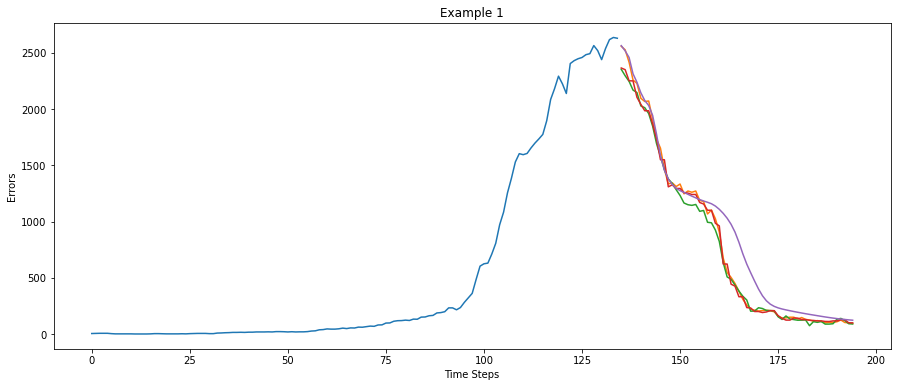

In [24]:
#Make Forecasts:
print("Predict the last ",n_out," Values of the last Vehicle Development Project:\n")
#Flatten Data
history = [x for x in train] #Note: History = train
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
AN_yhat = AN_model.predict(input_x, verbose=0)
TCN_yhat = TCN_model.predict(input_x, verbose=0)
GRU_yhat = GRU_model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
AN_yhat = AN_yhat[0]
TCN_yhat = TCN_yhat[0]
GRU_yhat = GRU_yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
y = train_y.reshape((train_y.shape[0]*train_y.shape[1], train_y.shape[2]))[-n_out:]
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 1")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], y[:])
plt.plot(time[135:195], AN_yhat[:])
plt.plot(time[135:195], TCN_yhat[:])
plt.plot(time[135:195], GRU_yhat[:])

plt.show()


Multi-Head Attention Network: [363.600] 117.4, 113.3, 117.9, 147.3, 153.0, 169.6, 182.7, 197.7, 182.8, 187.9, 203.8, 204.2, 207.5, 201.6, 206.4, 207.1, 209.3, 206.6, 205.6, 211.7, 209.6, 212.3, 206.2, 204.8, 194.9, 193.8, 193.3, 199.0, 196.8, 198.5, 189.3, 186.4, 188.4, 180.7, 181.7, 178.3, 177.4, 173.6, 171.7, 157.4, 154.2, 152.3, 149.2, 144.4, 139.1, 131.9, 130.5, 124.5, 118.5, 114.3, 108.1, 105.1, 100.2, 94.8, 95.2, 94.3, 90.8, 86.2, 81.0, 80.8


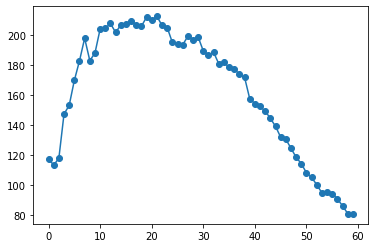

Overall MAE:  363.6004540613206
Temporal Convolutional Network: [515.816] 250.0, 240.8, 239.7, 260.4, 294.6, 285.5, 293.0, 304.5, 306.5, 299.6, 308.7, 309.7, 327.7, 308.6, 300.7, 299.9, 298.7, 298.1, 294.5, 300.8, 302.4, 292.4, 270.8, 261.9, 258.6, 246.3, 250.6, 247.6, 246.4, 241.4, 226.8, 216.4, 215.1, 200.7, 198.7, 193.7, 180.0, 169.7, 166.5, 158.2, 154.3, 147.8, 139.9, 143.0, 129.0, 120.5, 113.1, 108.8, 102.8, 97.6, 92.6, 90.7, 86.0, 81.8, 80.1, 76.5, 76.6, 74.7, 71.5, 70.9


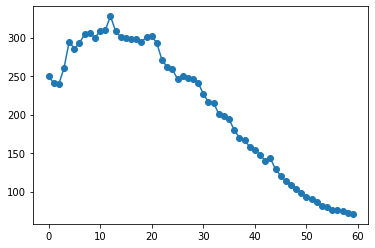

Overall MAE:  515.8164947440126
GRU Neural Network: [653.319] 292.8, 280.4, 288.8, 301.5, 301.5, 305.8, 309.1, 302.1, 289.3, 282.0, 284.8, 282.6, 275.3, 260.1, 254.7, 261.8, 268.9, 275.5, 280.4, 293.8, 296.5, 298.1, 301.6, 303.4, 310.8, 312.0, 314.1, 313.9, 316.7, 320.0, 319.2, 316.8, 307.9, 305.4, 298.3, 300.7, 299.1, 298.8, 295.1, 291.9, 289.3, 285.6, 280.8, 285.2, 279.3, 271.5, 265.5, 253.2, 243.2, 231.2, 207.3, 182.9, 165.4, 163.4, 163.9, 161.3, 158.0, 155.1, 149.9, 149.3


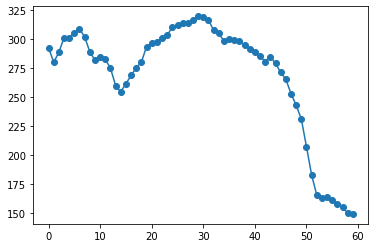

Overall MAE:  653.3189783712088


In [26]:
#Evaluate the Model:

AN_predictions = list()
TCN_predictions = list()
GRU_predictions = list()

#print("Test Shape: ",test.shape)
for i in range(test.shape[0]):
    #Predict the Output Sequence
    history = test[i:i+1,:,:] #for each Car Project
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        
    #Retrieve last Observations for Input Data
    input_x = data[-n_input-n_out:-n_out, :]
    
    #Reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
    
    #Forecast
    AN_yhat = AN_model.predict(input_x, verbose=0)
    TCN_yhat = TCN_model.predict(input_x, verbose=0)
    GRU_yhat = GRU_model.predict(input_x, verbose=0)
    
    #We only want the Vector Forecast
    AN_yhat_sequence = AN_yhat[0]
    TCN_yhat_sequence = TCN_yhat[0]
    GRU_yhat_sequence = GRU_yhat[0]
        
    #Store the Predictions
    AN_predictions.append(AN_yhat_sequence)
    TCN_predictions.append(TCN_yhat_sequence)
    GRU_predictions.append(GRU_yhat_sequence)
        
#Evaluate predicted Time Steps for each Car Project
AN_predictions = array(AN_predictions)
TCN_predictions = array(TCN_predictions)
GRU_predictions = array(GRU_predictions)

AN_scores = list()
TCN_scores = list()
GRU_scores = list()

actual, AN_predicted = array(y_test), array(AN_predictions)
actual, TCN_predicted = array(y_test), array(TCN_predictions)
actual, GRU_predicted = array(y_test), array(GRU_predictions)


for i in range(AN_predicted.shape[1]):
    #Calculate MSE
    #mse = mean_squared_error(actual[:, i], predicted[:, i])
    
    #Calculate RMSE
    #rmse = sqrt(mse)
    
    #Calculate MAE
    AN_mae = mean_absolute_error(actual[:, i], AN_predicted[:, i])
    TCN_mae = mean_absolute_error(actual[:, i], TCN_predicted[:, i])
    GRU_mae = mean_absolute_error(actual[:, i], GRU_predicted[:, i])
    #print("Step: ",i)
    #print("y", actual[:,i])
    #print("yhat", predicted[:,i])
    #print("MAE: ", mae)
    
    #Store the Scores
    #scores.append(rmse)
    AN_scores.append(AN_mae)
    TCN_scores.append(TCN_mae)
    GRU_scores.append(GRU_mae)

#Calculate overall MAE (alternative: RMSE)
AN_s = 0
TCN_s = 0
GRU_s = 0
    
for row in range(AN_predicted.shape[0]):
    for col in range(AN_predicted.shape[1]):
        AN_s += (actual[row, col] - AN_predicted[row, col])**2
        TCN_s += (actual[row, col] - TCN_predicted[row, col])**2
        GRU_s += (actual[row, col] - GRU_predicted[row, col])**2
    
AN_score = sqrt(AN_s / (actual.shape[0] * actual.shape[1]))
TCN_score = sqrt(TCN_s / (actual.shape[0] * actual.shape[1]))
GRU_score = sqrt(GRU_s / (actual.shape[0] * actual.shape[1]))

#Visualize AN_MAE
AN_s_scores = ', '.join(['%.1f' % AN_s for AN_s in AN_scores])
print('%s: [%.3f] %s' % ('Multi-Head Attention Network', AN_score, AN_s_scores))
pyplot.plot(AN_scores, marker='o', label='AN')
pyplot.show()
print("Overall MAE: ",AN_score)

#Visualize TCN_MAE
TCN_s_scores = ', '.join(['%.1f' % TCN_s for TCN_s in TCN_scores])
print('%s: [%.3f] %s' % ('Temporal Convolutional Network', TCN_score, TCN_s_scores))
pyplot.plot(TCN_scores, marker='o', label='TCN')
pyplot.show()
print("Overall MAE: ",TCN_score)

#Visualize GRU_MAE
GRU_s_scores = ', '.join(['%.1f' % GRU_s for GRU_s in GRU_scores])
print('%s: [%.3f] %s' % ('GRU Neural Network', GRU_score, GRU_s_scores))
pyplot.plot(GRU_scores, marker='o', label='GRU')
pyplot.show()
print("Overall MAE: ",GRU_score)


In [27]:
###########################################################################################################################
########################################## Visualization of Predicted Data ################################################
###########################################################################################################################

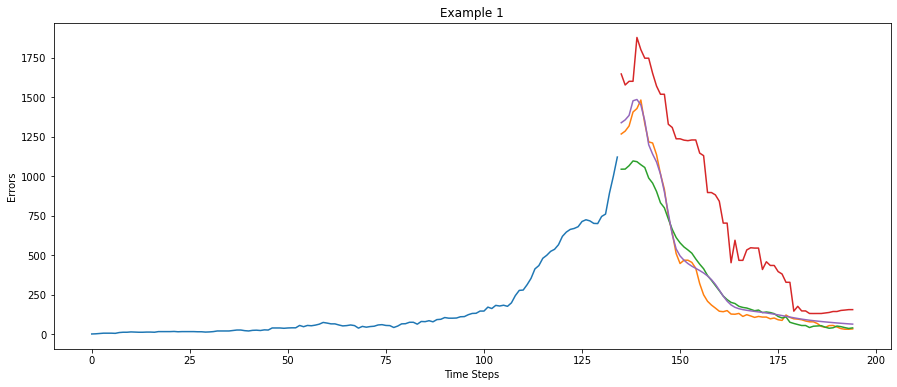

In [47]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 1
example=1

X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
AN_prediction_data=AN_predicted.reshape((AN_predicted.shape[0]*AN_predicted.shape[1]))
TCN_prediction_data=TCN_predicted.reshape((TCN_predicted.shape[0]*TCN_predicted.shape[1]))
GRU_prediction_data=GRU_predicted.reshape((GRU_predicted.shape[0]*GRU_predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example "+str(example))

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], AN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], TCN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], GRU_prediction_data[(example-1)*n_out:example*n_out])

plt.show()

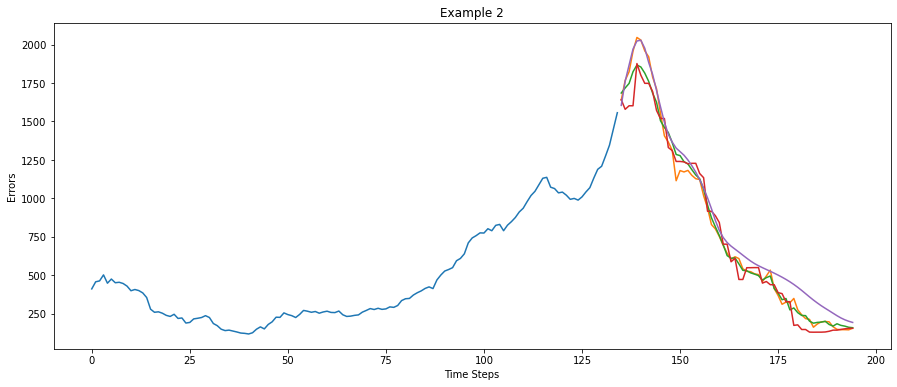

In [48]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 2
example=2
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
AN_prediction_data=AN_predicted.reshape((AN_predicted.shape[0]*AN_predicted.shape[1]))
TCN_prediction_data=TCN_predicted.reshape((TCN_predicted.shape[0]*TCN_predicted.shape[1]))
GRU_prediction_data=GRU_predicted.reshape((GRU_predicted.shape[0]*GRU_predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example "+str(example))

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], AN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], TCN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], GRU_prediction_data[(example-1)*n_out:example*n_out])

plt.show()

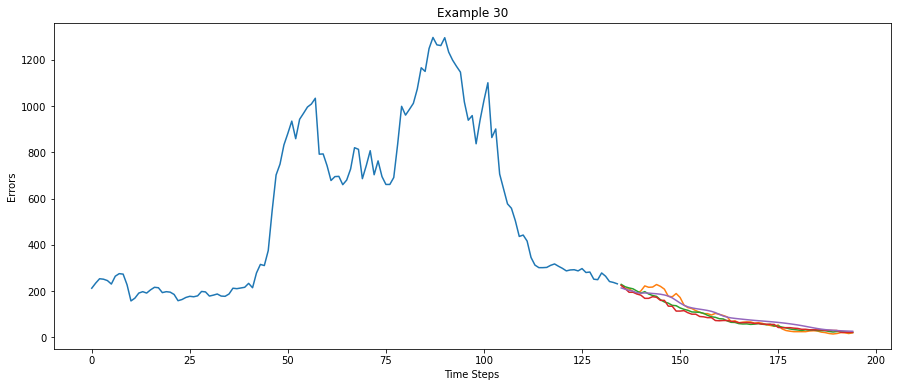

In [49]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 3
example=30
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
AN_prediction_data=AN_predicted.reshape((AN_predicted.shape[0]*AN_predicted.shape[1]))
TCN_prediction_data=TCN_predicted.reshape((TCN_predicted.shape[0]*TCN_predicted.shape[1]))
GRU_prediction_data=GRU_predicted.reshape((GRU_predicted.shape[0]*GRU_predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example "+str(example))

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], AN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], TCN_prediction_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], GRU_prediction_data[(example-1)*n_out:example*n_out])

plt.show()

In [36]:
###########################################################################################################################
########################################## Verifikation am realen Beispiel ################################################
###########################################################################################################################

Predict the last 60 Values of the test vehicle project:



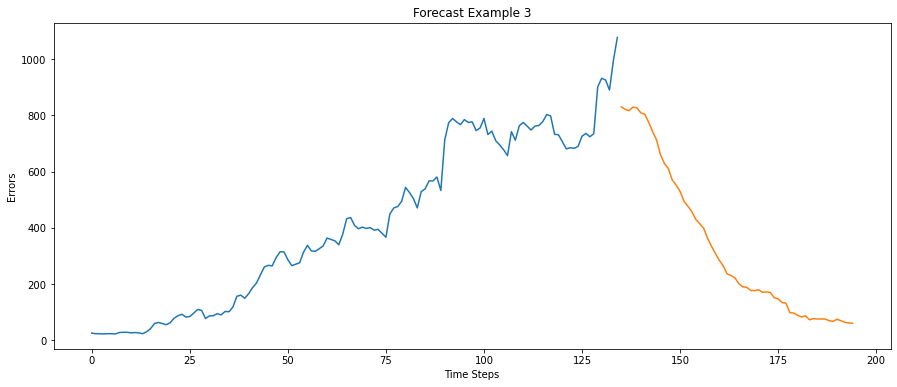

In [201]:
#Import Validation Data
validation_data = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/X_Test_Prediction_multivariat_preprocessed_v03e_20211003_OB.xlsm',0)
#print('Shape des RAW-Datasets: ',validation_data.shape)
validation_data.head()

#Drop unneccessary Columns:
validation_data = validation_data.iloc[:,3:5]
#print('Shape of the Dataset: ',validation_data.shape)
#print(validation_data.head())

#Normalize Input Data
#scaler = MinMaxScaler()
#validation_data_scaled = scaler.fit_transform(validation_data)

#Set nth sample to show
n=3

#Manuelle Definition Array erstes reales Verifikationsbeispiel x1 
#x1 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x1 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x1 = array(split(x1, len(x1)/195))
#print("Shape x1: \n",x1.shape,"\n")
#print("x1: \n",x1)

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x1 #Note: History = x1
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
AN_yhat = AN_model.predict(input_x, verbose=0)
TCN_yhat = TCN_model.predict(input_x, verbose=0)
GRU_yhat = GRU_model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
AN_yhat = AN_yhat[0]
TCN_yhat = TCN_yhat[0]
GRU_yhat = GRU_yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Forecast Example "+str(n))

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], AN_yhat[:])
#plt.plot(time[135:195], TCN_yhat[:])
#plt.plot(time[135:195], GRU_yhat[:])

plt.show()


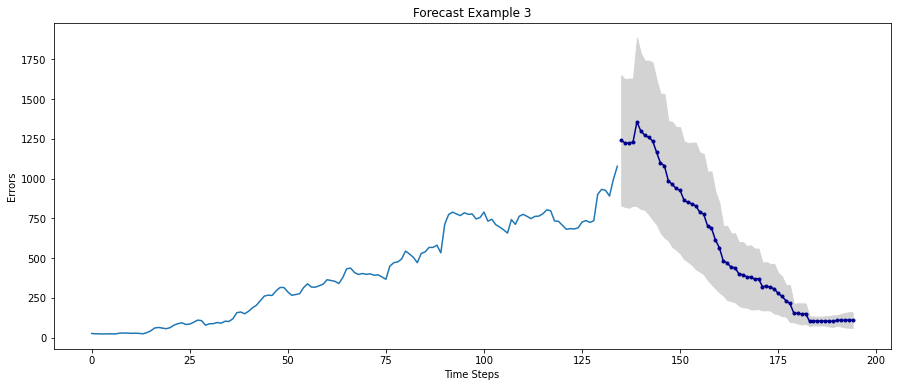

In [220]:
#Generate Forecast Integral
#find max, min and average value vectors 
max, min, avg = list(), list(), list()
for i in range(len(AN_yhat)):        
    if AN_yhat[i] > TCN_yhat[i]:
        max.append(AN_yhat[i])
    else: max.append(TCN_yhat[i])

for i in range(len(AN_yhat)):        
    if AN_yhat[i] < TCN_yhat[i]:
        min.append(AN_yhat[i])
    else: min.append(TCN_yhat[i])

for i in range(len(AN_yhat)):        
    avg_value = 1/2*(AN_yhat[i]+TCN_yhat[i])
    avg.append(avg_value)
        
#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Forecast Example "+str(n))

plt.plot(time[0:135], X[:])
#plt.plot(time[135:195], max[:],color='orange')
#plt.plot(time[135:195], min[:],color='orange')
plt.plot(time[135:195], avg[:],color='darkblue',marker='.')
plt.fill_between(time[135:195],np.reshape(np.array(max),-1), np.reshape(np.array(min),-1),color='lightgrey')

plt.show()